In [ ]:
!pip install pandas spacy nltk python-Levenshtein
!python -m nltk.downloader wordnet punkt
!python -m spacy download en_core_web_md

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.3 MB/s eta 0:00:00
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 50.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import numpy as np
import Levenshtein
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import spacy
import nltk
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
nlp = spacy.load("en_core_web_md")

In [ ]:
lemmatizer = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))

#### Some comon abbreviations

In [ ]:
CUSTOM_ABBREVIATIONS = {
    "eg": "example",
    "e.g.": "example",
    "ex": "example",
    "e.x.": "example",
    "i.e.": "that is",
    "etc": "etcetera",
    "vs": "versus",
    "w/": "with",
    "w": "with",
    "w/o": "without",
    "char": "characteristic",
    "def": "definition",
    "eqn": "equation",
    "fig": "figure",
    "max": "maximum",
    "min": "minimum",
    "approx": "approximately",
    "apprx": "approximately",
    "approx.": "approximately",
    "ref": "reference",
    "esp": "especially",
    "std": "standard",
    "bc": "because",
}

In [ ]:
def expand_abbreviations(text):
    for abbr, full_text in CUSTOM_ABBREVIATIONS.items():
        # Use regex to match whole words or common abbreviation patterns
        text = re.sub(r'\b' + re.escape(abbr) + r'\b\.?', full_text, text, flags=re.IGNORECASE)
    return text

In [ ]:
def get_proper_nouns(text):
    if not isinstance(text, str) or not text.strip():
        return []
    # Minimal cleaning for POS tagging
    text_for_pos = text.replace("-", " ")
    tokens = word_tokenize(text_for_pos)
    tagged_tokens = pos_tag(tokens)
    proper_nouns = [word.lower() for word, tag in tagged_tokens if tag in ('NNP', 'NNPS')]
    # Lemmatize proper nouns as well for consistency in matching
    return [lemmatizer.lemmatize(pn) for pn in proper_nouns]

In [ ]:
def preprocess(text, remove_stop_words=False):
    if not isinstance(text, str):
        return []

    text = text.lower()
    text = expand_abbreviations(text)

    # Specific replacements (do these after general abbrev. expansion if they conflict)
    text = (text.replace("ex)", "example") # Often written without space
            .replace("-", " ") # Replace hyphens with space
            )

    words = [w for w in word_tokenize(text) if w.isalnum()] # Tokenize and remove punctuation

    if remove_stop_words:
        words = [w for w in words if w not in STOP_WORDS]

    return [lemmatizer.lemmatize(w) for w in words]

### Rule Definitions

In [ ]:
def get_ngrams_from_tokens(tokens, n_values=[1, 2]):
    """Generate n-grams from already tokenized text."""
    ngrams_set = set()
    for n in n_values:
        if len(tokens) >= n:
            for i in range(len(tokens) - n + 1):
                ngrams_set.add(' '.join(tokens[i:i+n]))
    return list(ngrams_set)

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            syn_word = lemma.name().lower().replace('_', ' ')
            synonyms.add(syn_word)
    return synonyms

def calculate_semantic_similarity(idea_unit_text, note_text, threshold=0.75):
    # Preprocess for spaCy (it handles its own tokenization, but consistency helps)
    # Using already preprocessed text for spaCy might be better if a lot of custom cleaning was done.
    # However, spaCy's pipeline is robust. Let's use minimally processed text for spaCy.

    # Using raw text might be better for spaCy's context understanding
    # but for consistency with other rules, let's use the output of preprocess (without stopword removal for spaCy)

    doc1_text = " ".join(preprocess(idea_unit_text, remove_stop_words=False))
    doc2_text = " ".join(preprocess(note_text, remove_stop_words=False))

    if not doc1_text.strip() or not doc2_text.strip():
        return False # Cannot compare if one is empty

    doc1 = nlp(doc1_text)
    doc2 = nlp(doc2_text)

    # Handle cases where spaCy might not produce a vector
    if not doc1.has_vector or not doc2.has_vector or doc1.vector_norm == 0 or doc2.vector_norm == 0:
        return False # or handle with a different logic, e.g., keyword match

    raw_score = doc1.similarity(doc2)


    if "property" in idea_unit_text.lower() or "definition" in idea_unit_text.lower() or "law" in idea_unit_text.lower():
        return raw_score >= threshold + 0.05 # Stricter for abstract
    elif "example" in idea_unit_text.lower():
         return raw_score >= threshold - 0.05 # More lenient for examples
    else:
        return raw_score >= threshold

def calculate_keyword_ngram_overlap(idea_unit_text, note_text, threshold=0.5, ngram_n_values=[1,2]):
    idea_tokens = preprocess(idea_unit_text, remove_stop_words=True) # Remove stop words for IU keywords
    note_tokens = preprocess(note_text, remove_stop_words=False) # Keep stop words in notes for phrase context

    if not idea_tokens: # If idea unit is empty after preprocessing
        return False

    idea_grams = get_ngrams_from_tokens(idea_tokens, n_values=ngram_n_values)
    note_grams = get_ngrams_from_tokens(note_tokens, n_values=ngram_n_values)

    if not idea_grams: # If no n-grams could be formed from idea_tokens
        return False

    overlap_count = len([gram for gram in idea_grams if gram in note_grams])

    # print(f"IU: {idea_unit_text}, Note: {note_text}")
    # print(f"Idea Grams: {idea_grams}, Note Grams: {note_grams}, Overlap: {overlap_count}")
    # print(f"Overlap Score: {overlap_count / len(idea_grams)}")

    return (overlap_count / len(idea_grams)) >= threshold

def check_strict_proper_noun_match(idea_unit_proper_nouns, note_text, max_distance_ratio=0.2):
    """
    Checks if proper nouns from IdeaUnit are present or closely matched in the note.
    max_distance_ratio: Levenshtein distance allowed, as a ratio of the PN length.
    """
    if not idea_unit_proper_nouns: # No proper nouns to check
        return True # Vacuously true

    note_tokens = preprocess(note_text, remove_stop_words=False) # Lemmatized, lowercased note tokens
    if not note_tokens:
        return False # Cannot match if note is empty

    for pn in idea_unit_proper_nouns: # Already lowercased and lemmatized
        found_match = False
        for note_word in note_tokens:
            distance = Levenshtein.distance(pn, note_word)
            # Allow for small typos based on length of proper noun
            if distance <= max(1, int(len(pn) * max_distance_ratio)): # at least 1, or ratio based
                found_match = True
                break
        if not found_match:
            # print(f"PN False: {pn} not in {note_tokens}")
            return False # A required proper noun was not found
    return True

def check_synonym_keyword_match(idea_unit_text, note_text, min_keyword_match_ratio=0.5):
    iu_keywords = preprocess(idea_unit_text, remove_stop_words=True)
    note_tokens = preprocess(note_text, remove_stop_words=False)

    if not iu_keywords:
        return False
    if not note_tokens:
        return False

    matched_keyword_count = 0
    for iu_kw in iu_keywords:
        if iu_kw in note_tokens:
            matched_keyword_count += 1
            continue
        syns = get_synonyms(iu_kw)
        if any(s in note_tokens for s in syns):
             matched_keyword_count += 1
             continue


    return (matched_keyword_count / len(iu_keywords)) >= min_keyword_match_ratio

### Prediction With Custom Thresholds

In [ ]:
def predict_label_enhanced(
    idea_unit_text,
    note_text,
    idea_unit_proper_nouns,
    min_note_len=3, # Min number of tokens in preprocessed note
    # Semantic thresholds
    sem_sim_thresh_strict=0.80, # For high confidence semantic match
    sem_sim_thresh_moderate=0.70, # For moderate confidence semantic match
    sem_sim_thresh_lenient=0.60,  # For low-ish confidence semantic match
    # N-gram overlap thresholds
    ngram_overlap_thresh_strict=0.75,
    ngram_overlap_thresh_moderate=0.50,
    ngram_overlap_thresh_lenient=0.30,
    # Synonym match threshold
    synonym_match_ratio_thresh=0.6, # at least 60% of keywords (or their synonyms) found in note
    # Proper Noun check
    perform_pn_check = True, # Flag for checking proper nouns
    pn_max_distance_ratio = 0.2
):
    processed_note_tokens = preprocess(note_text)
    # Negative Rule 1: Note too short
    if len(processed_note_tokens) < min_note_len:
        return 0
    # Negative Rule 2: Key proper noun missing/mismatched
    if perform_pn_check:
        if not check_strict_proper_noun_match(idea_unit_proper_nouns, note_text, pn_max_distance_ratio):
            return 0

    # Positive Rules

    # Rule 1: High Confidence - Strong Semantic AND Strong N-gram
    if calculate_semantic_similarity(idea_unit_text, note_text, sem_sim_thresh_strict) and \
       calculate_keyword_ngram_overlap(idea_unit_text, note_text, ngram_overlap_thresh_strict):
        return 1

    # Rule 2: Moderate Confidence - Good Semantic OR Good N-gram, with the other being at least lenient
    sem_ok_moderate = calculate_semantic_similarity(idea_unit_text, note_text, sem_sim_thresh_moderate)
    ngram_ok_moderate = calculate_keyword_ngram_overlap(idea_unit_text, note_text, ngram_overlap_thresh_moderate)
    sem_ok_lenient = calculate_semantic_similarity(idea_unit_text, note_text, sem_sim_thresh_lenient)
    ngram_ok_lenient = calculate_keyword_ngram_overlap(idea_unit_text, note_text, ngram_overlap_thresh_lenient)

    if (sem_ok_moderate and ngram_ok_lenient) or (sem_ok_lenient and ngram_ok_moderate):
        return 1

    # Rule 3: Focus on N-gram/Keyword overlap for very specific terms.
    if calculate_keyword_ngram_overlap(idea_unit_text, note_text, ngram_overlap_thresh_strict, ngram_n_values=[1,2,3]):
        # Add a lenient semantic check to avoid purely coincidental keyword matches if desired
        if sem_ok_lenient:
             return 1


    # Rule 4: Synonym-based keyword matching
    if check_synonym_keyword_match(idea_unit_text, note_text, synonym_match_ratio_thresh):
        # Optionally, add a weak semantic check here too
        if sem_ok_lenient: # Ensure it's not completely off-topic semantically
            return 1

    # Rule 5: Short Idea Unit - high keyword overlap needed
    processed_iu_tokens_for_short_check = preprocess(idea_unit_text, remove_stop_words=True)
    if 1 <= len(processed_iu_tokens_for_short_check) <= 4: # e.g., IU is "laser characteristics"
        # For short IUs, demand a higher overlap of these specific terms
        if calculate_keyword_ngram_overlap(idea_unit_text, note_text, threshold=0.80, ngram_n_values=[1]): # Check unigrams with high threshold
            return 1


    return 0 # Default: No rule matched


In [ ]:
def print_metrics(y_true, y_pred, title_prefix=""):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n{title_prefix} Classification Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    plt.figure(figsize=(9, 10))
    sns.set_theme(style="whitegrid")
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
    ax.set_xlabel('Predicted Labels\n(0 = Not Covered, 1 = Covered)', fontsize=12)
    ax.set_ylabel('True Labels\n(0 = Not Covered, 1 = Covered)', fontsize=12)
    ax.set_title(f'{title_prefix} Confusion Matrix', fontsize=14, pad=20)
    plt.text(0.5, -0.15, # Adjusted position for better layout
             f"Accuracy: {accuracy:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}",
             ha='center', va='center', transform=ax.transAxes,
             bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8, ec='gray'))
    plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust layout to prevent cutting off text
    plt.show()
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "cm": cm}


In [ ]:
def load_and_prepare_data(notes_path, labels_path):
    encodings = ['utf-8', 'cp1252', 'latin1', 'iso-8859-1']
    notes_df, labels_df = None, None
    for encoding in encodings:
        try:
            notes_df = pd.read_csv(notes_path, encoding=encoding)
            notes_df.columns = notes_df.columns.str.strip()

            labels_df = pd.read_csv(labels_path, encoding=encoding)
            labels_df.columns = labels_df.columns.str.strip()

            break
        except UnicodeDecodeError:
            if encoding == encodings[-1]:
                raise Exception("Failed to decode CSV file")
            continue # Try next encoding
        except FileNotFoundError as e:
            raise e

    # Prepare notes_df for merging:
    id_vars_notes = ['Topic', 'ID']
    id_vars_notes = [col for col in id_vars_notes if col in notes_df.columns]
    if not id_vars_notes:
        raise ValueError("Critical join columns (Topic, ID) not found in Notes.csv")

    value_vars = [col for col in notes_df.columns if 'Segment' in col and '_Notes' in col]
    notes_long_df = notes_df.melt(id_vars=id_vars_notes, value_vars=value_vars, var_name='Segment_Col', value_name='Note')

    notes_long_df['Segment'] = notes_long_df['Segment_Col'].str.extract(r'Segment(\d+)_Notes').astype(int)
    notes_long_df.drop(columns=['Segment_Col'], inplace=True)

    # Merge with labels_df
    labels_df['Segment'] = labels_df['Segment'].astype(int)

    merge_on_cols = ['Topic', 'ID', 'Segment']
    labels_cols_present = [col for col in merge_on_cols if col in labels_df.columns]
    notes_long_cols_present = [col for col in merge_on_cols if col in notes_long_df.columns]

    # Use only common columns present in both for merging to avoid KeyErrors
    final_merge_cols = list(set(labels_cols_present) & set(notes_long_cols_present))
    if not all(col in final_merge_cols for col in ['ID', 'Segment']): # ID and Segment are essential
         raise ValueError("Essential columns 'ID' or 'Segment' are missing for merging.")


    merged_df = pd.merge(labels_df, notes_long_df, on=final_merge_cols, how='left')

    merged_df['IdeaUnit_ProperNouns'] = merged_df['IdeaUnit'].apply(get_proper_nouns)
    merged_df['Note'] = merged_df['Note'].fillna("")

    # Ensure the final dataframe has the expected columns for downstream processing
    expected_final_cols = ['ID', 'Segment', 'IdeaUnit', 'IdeaUnit_ProperNouns', 'Note', 'label']
    # Add Topic if it was part of the merge and is needed later (though not in expected_final_cols for model)
    if 'Topic' in final_merge_cols:
        expected_final_cols.insert(1, 'Topic')
    return merged_df[expected_final_cols]

Loading and preparing training data...
Training data loaded: 255 records
Label distribution in train_data: Counter({0: 131, 1: 124})

Loading and preparing test data...
Test data loaded: 9945 records
Test data after dropping NA labels: 9941 records
Label distribution in test_data_clean: Counter({0.0: 6350, 1.0: 3591})

Predicting on Training Data (using enhanced model)...

Train Set (Enhanced Model) Classification Metrics:
Accuracy: 0.6627
Precision: 0.6532
Recall: 0.6532
F1 Score: 0.6532


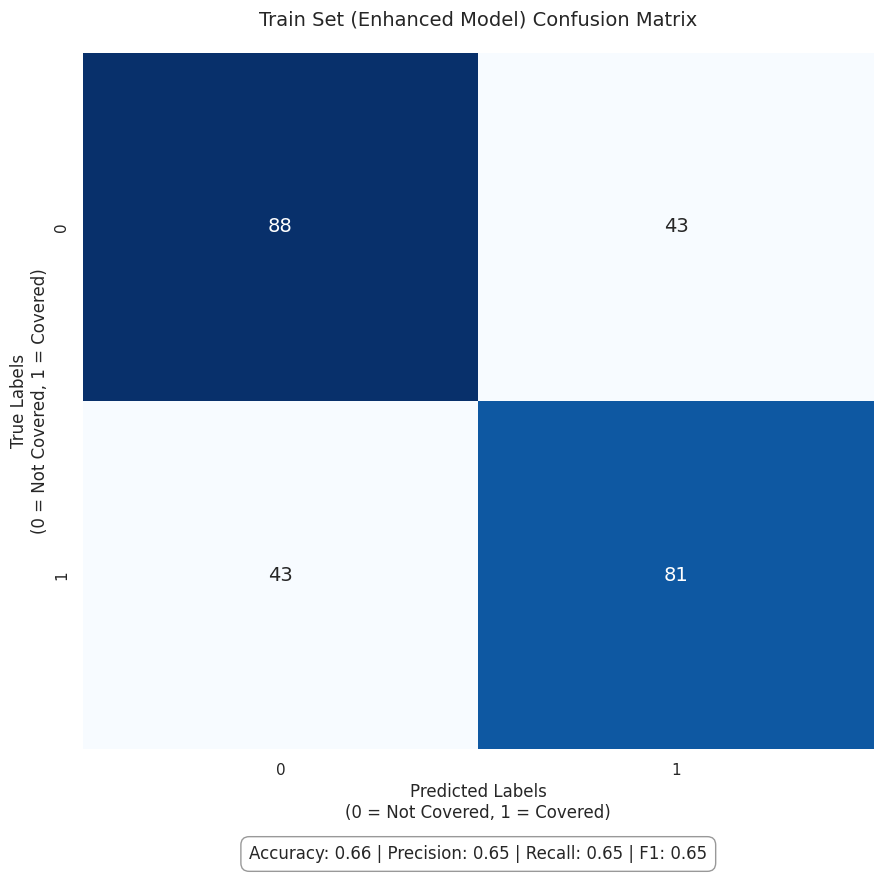


Predicting on Test Data (using enhanced model)...

Test Set (Enhanced Model) Classification Metrics:
Accuracy: 0.7220
Precision: 0.6383
Recall: 0.5313
F1 Score: 0.5799


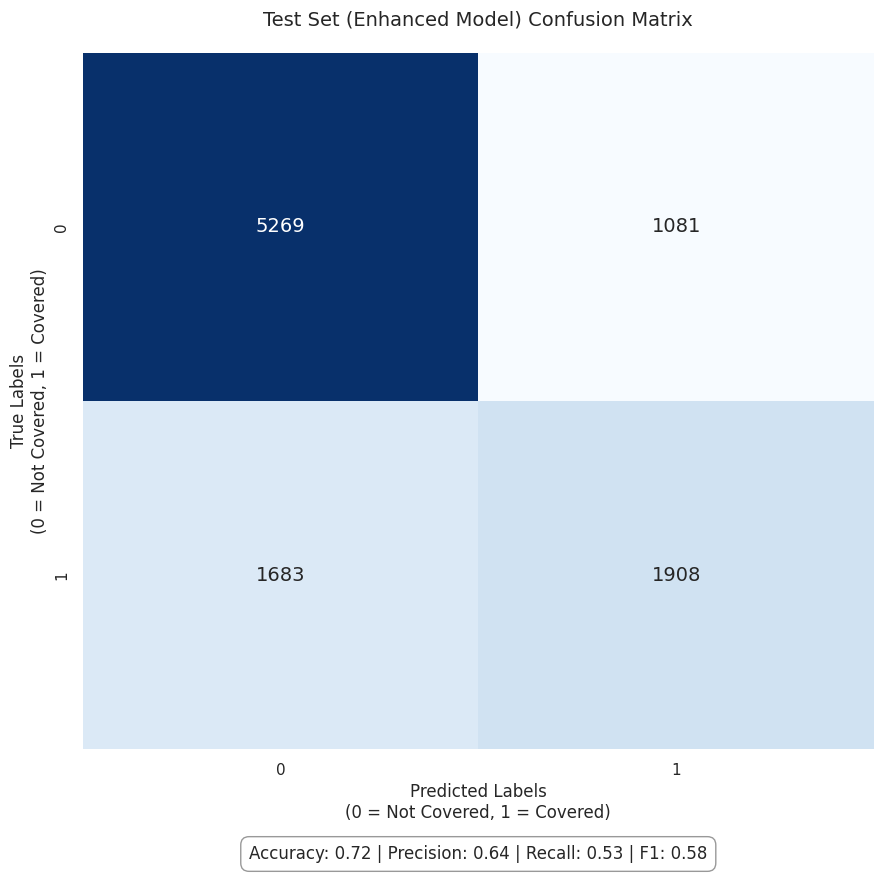


--- Student Note-Taking Performance (based on model predictions on Test Set) ---

Per-Segment Predicted Capture Rate by Student (% of IdeaUnits model predicted as covered):
          ID  Segment  PredictedCoveredIUs  TotalIUsExpectedInSegment  \
0    6260220        1                    5                         14   
1    6260220        2                    5                         14   
2    6260220        3                    8                         14   
3    6260220        4                    4                         14   
4    6260221        1                    4                         14   
..       ...      ...                  ...                        ...   
619  7790975        4                    0                         15   
620  7859427        1                    4                         18   
621  7859427        2                    5                         19   
622  7859427        3                    6                         18   
623  7859427        4  

In [ ]:
print("Loading and preparing training data...")
notes_csv_path = "/content/drive/MyDrive/FinalProj/Notes.csv"
train_csv_path = "/content/drive/MyDrive/FinalProj/train.csv"
test_csv_path = "/content/drive/MyDrive/FinalProj/test.csv"
train_data = load_and_prepare_data(notes_csv_path, train_csv_path)
print(f"Training data loaded: {train_data.shape[0]} records")
print("Label distribution in train_data:", Counter(train_data['label']))


print("\nLoading and preparing test data...")
test_data = load_and_prepare_data(notes_csv_path, test_csv_path)
print(f"Test data loaded: {test_data.shape[0]} records")

# Handle potential NaN labels if any exist in test_data (though load_and_prepare should be robust)
test_data_clean = test_data.dropna(subset=['label']).copy()
print(f"Test data after dropping NA labels: {test_data_clean.shape[0]} records")
print("Label distribution in test_data_clean:", Counter(test_data_clean['label']))


#Predicting on Training Data (using enhanced model)
train_data['pred'] = train_data.apply(
    lambda x: predict_label_enhanced(
        x['IdeaUnit'], x['Note'], x['IdeaUnit_ProperNouns'],
        # You can override default thresholds here if needed for tuning:
        # sem_sim_thresh_moderate=0.65, ngram_overlap_thresh_moderate=0.45, etc.
        perform_pn_check=True # Enable or disable PN check
    ), axis=1
)
train_metrics = print_metrics(train_data['label'], train_data['pred'], title_prefix="Train Set (Enhanced Model)")

print("\nPredicting on Test Data (using enhanced model)...")
test_data_clean.loc[:, 'pred'] = test_data_clean.apply(
lambda x: predict_label_enhanced(
x['IdeaUnit'], x['Note'], x['IdeaUnit_ProperNouns'],
perform_pn_check=True
), axis=1
)
test_metrics = print_metrics(test_data_clean['label'], test_data_clean['pred'], title_prefix="Test Set (Enhanced Model)")

# --- Student Performance Metrics ---
print("\n--- Student Note-Taking Performance (based on model predictions on Test Set) ---")

# We need 'ID', 'Segment', 'label' (actual coverage), 'pred' (model predicted coverage)
# And a count of total IdeaUnits per student-segment.

# Calculate number of IdeaUnits model predicted as covered for each student-segment
student_segment_pred_coverage = test_data_clean.groupby(['ID', 'Segment'])['pred'].agg(['sum', 'count']).reset_index()
student_segment_pred_coverage.rename(columns={'sum': 'PredictedCoveredIUs', 'count': 'TotalIUsExpectedInSegment'}, inplace=True)
student_segment_pred_coverage['PredictedCaptureRate_Segment'] = \
(student_segment_pred_coverage['PredictedCoveredIUs'] / student_segment_pred_coverage['TotalIUsExpectedInSegment']) * 100

print("\nPer-Segment Predicted Capture Rate by Student (% of IdeaUnits model predicted as covered):")
print(student_segment_pred_coverage)

# Calculate overall predicted capture rate per student
student_overall_pred_coverage = student_segment_pred_coverage.groupby('ID').agg(
TotalPredictedCoveredIUs_Overall = ('PredictedCoveredIUs', 'sum'),
TotalIUsExpected_Overall = ('TotalIUsExpectedInSegment', 'sum')
).reset_index()
student_overall_pred_coverage['OverallPredictedCaptureRate_Student'] = \
(student_overall_pred_coverage['TotalPredictedCoveredIUs_Overall'] / student_overall_pred_coverage['TotalIUsExpected_Overall']) * 100

print("\nOverall Predicted Capture Rate by Student (% of IdeaUnits model predicted as covered):")
print(student_overall_pred_coverage)


# If you want to compare against actual labels (how well student notes *actually* covered IUs,
# and how well our model detects that coverage)
# This section analyzes the student's actual performance based on ground truth labels,
# and then how our model's predictions align.

print("\n--- Student Actual Note-Taking Performance (based on ground truth 'label') ---")
student_segment_actual_coverage = test_data_clean.groupby(['ID', 'Segment'])['label'].agg(
    ActualCoveredIUs_Segment = 'sum',
    TotalIUs_Segment = 'count' # Total IUs defined for this segment for the student
).reset_index()
student_segment_actual_coverage['ActualCaptureRate_Segment'] = \
    (student_segment_actual_coverage['ActualCoveredIUs_Segment'] / student_segment_actual_coverage['TotalIUs_Segment']) * 100

print("\nPer-Segment Actual Capture Rate by Student (based on 'label'):")
print(student_segment_actual_coverage)

student_overall_actual_coverage = student_segment_actual_coverage.groupby('ID').agg(
    TotalActualCoveredIUs_Overall = ('ActualCoveredIUs_Segment', 'sum'),
    TotalIUs_Overall = ('TotalIUs_Segment', 'sum')
).reset_index()
student_overall_actual_coverage['OverallActualCaptureRate_Student'] = \
      (student_overall_actual_coverage['TotalActualCoveredIUs_Overall'] / student_overall_actual_coverage['TotalIUs_Overall']) * 100

print("\nOverall Actual Capture Rate by Student (based on 'label'):")
print(student_overall_actual_coverage)

# You could further merge these dataframes to compare model prediction rates vs actual rates per student.

# Save predictions if needed
test_data_clean[['ID', 'Segment', 'IdeaUnit', 'pred']].to_csv("predictions_v6.csv", index=False)
print("\nPredictions saved to 'predictions_v6.csv'")
